In [41]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset
from IPython import display
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import pyplot as plt
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [42]:
california_housing_dataframe = pd.read_csv(
    "https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(
     np.random.permutation(california_housing_dataframe.index))

In [43]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[
        ["latitude", 
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]]
    processed_features = selected_features.copy()
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / 
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

In [44]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.5,2654.5,541.2,1436.4,502.9,3.9,2.0
std,2.1,2.0,12.6,2215.4,428.0,1157.4,389.5,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1454.8,296.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2124.0,432.0,1165.5,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3161.2,649.0,1729.0,606.0,4.8,2.3
max,42.0,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,52.0


In [45]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,206.9
std,115.7
min,15.0
25%,119.3
50%,179.7
75%,264.0
max,500.0


In [46]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.8,2617.6,535.1,1413.2,497.2,3.9,2.0
std,2.1,2.0,12.5,2092.5,405.5,1124.5,372.2,1.9,1.2
min,32.5,-124.3,2.0,15.0,3.0,11.0,3.0,0.5,0.1
25%,34.0,-121.8,18.0,1476.0,298.0,791.0,282.0,2.6,1.5
50%,34.3,-118.5,29.0,2149.5,438.0,1171.0,412.0,3.5,1.9
75%,37.7,-118.0,37.0,3135.5,648.0,1704.2,601.5,4.8,2.3
max,41.9,-114.5,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


In [47]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,208.2
std,116.6
min,15.0
25%,120.0
50%,181.3
75%,267.4
max,500.0


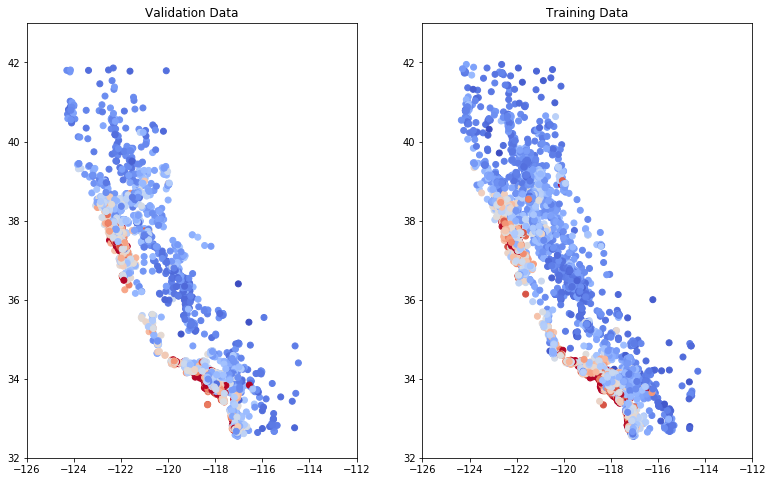

In [48]:
plt.figure(figsize=(13,8))
ax = plt.subplot(1,2,1)
ax.set_title("Validation Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(validation_examples["longitude"], 
            validation_examples["latitude"],
            cmap = "coolwarm",
            c = validation_targets["median_house_value"] / validation_targets["median_house_value"].max())
ax = plt.subplot(1,2,2)
ax.set_title("Training Data")
ax.set_autoscaley_on(False)
ax.set_ylim([32,43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126,-112])
plt.scatter(training_examples["longitude"], 
            training_examples["latitude"],
            cmap = "coolwarm",
            c = training_targets["median_house_value"] / training_targets["median_house_value"].max())

_ = plt.plot()

In [63]:
def my_input_fun(features, targets, batch_size = 1, shuffle = True, num_epochs = None):
    features = {key:np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [64]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [68]:
def train_model(
    learning_rate, 
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer)
    training_input_fun = lambda: my_input_fun(training_examples, 
                                              training_targets["median_house_value"], 
                                              batch_size = batch_size)
    predict_training_input_fun = lambda: my_input_fun(training_examples,
                                                      training_targets["median_house_value"],
                                                      num_epochs = 1,
                                                      shuffle = False)
    predict_validation_input_fun = lambda: my_input_fun(validation_examples,
                                                        validation_targets["median_house_value"],
                                                        num_epochs = 1,
                                                        shuffle = False)
    print("Training model ....")
    print("RMSE on training data: ")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        linear_regressor.train(input_fn = training_input_fun, steps = steps_per_period)
        training_predictions = linear_regressor.predict(input_fn = predict_training_input_fun)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fun)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        print("period %02d: %0.2f" %(period, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished")
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root mean squared error vs Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label = "training")
    plt.plot(validation_rmse, label = "validation")
    plt.legend()
    return linear_regressor        

Training model ....
RMSE on training data: 
period 00: 216.78
period 01: 198.90
period 02: 184.17
period 03: 173.69
period 04: 168.52
period 05: 166.47
period 06: 165.91
period 07: 166.28
period 08: 166.48
period 09: 166.20
Model training finished


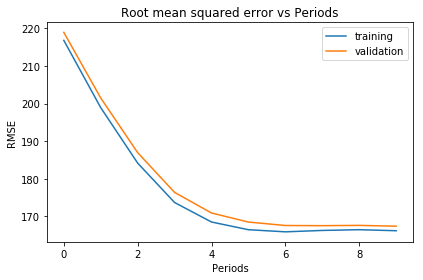

In [70]:
linear_regressor = train_model(
    learning_rate = 0.00003,
    steps = 500,
    batch_size = 50,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets)

In [75]:
california_housing_test_dataset = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_test.csv", sep=",")

In [76]:
test_examples = preprocess_features(california_housing_test_dataset)
test_targets = preprocess_targets(california_housing_test_dataset)
predict_test_input_fun = lambda: my_input_fun(test_examples, test_targets["median_house_value"],
                                             num_epochs = 1, shuffle = False)
test_predictions = linear_regressor.predict(input_fn = predict_test_input_fun)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data) : %0.2f" %root_mean_squared_error)

Final RMSE (on test data) : 160.62
